In [1]:
import pandas as pd
import sqlite3
import numpy as np

In [2]:
# assignmentID = 100
assignmentID = 139

query = f"""
select SubjectID, AssignmentID, CodeStateID, InterventionType, InterventionMessage, Contents from (
select SubjectID, AssignmentID, CodeStateID, InterventionType, InterventionMessage, CodeStateSection from MainTable where AssignmentId = "{assignmentID}" and InterventionCategory = "Feedback"
) as main JOIN CodeState where main.CodeStateID = CodeState.ID and main.CodeStateSection = CodeState.Filename
"""

con = sqlite3.connect("data/progsnap2_21_consenting_no_demographics.db")
df = pd.read_sql_query(query, con)

df["Correct"] = df.InterventionType == "complete|Complete"

df

,SubjectID,AssignmentID,CodeStateID,InterventionType,InterventionMessage,Contents,Correct
0,750,139,403848,algorithmic|Unused Variable,<p>The function <code class='pedal-name'>asser...,"b""from cisc108 import assert_equal\n\nnum_list...",False
1,750,139,403906,instructor|Student Unit Tests Failing,<p>2/3 of your unit tests are not passing.</p>\n,"b""from cisc108 import assert_equal\n\nnum_list...",False
2,750,139,403936,instructor|Student Unit Tests Failing,<p>1/3 of your unit tests are not passing.</p>\n,"b""from cisc108 import assert_equal\n\nnum_list...",False
3,750,139,403947,instructor|Student Unit Tests Failing,<p>3/3 of your unit tests are not passing.</p>\n,"b""from cisc108 import assert_equal\n\nnum_list...",False
4,750,139,403936,instructor|Student Unit Tests Failing,<p>1/3 of your unit tests are not passing.</p>\n,"b""from cisc108 import assert_equal\n\nnum_list...",False
...,...,...,...,...,...,...,...
1130,726,139,1021367,syntax|Syntax Error,<p>Bad syntax on line 22</p>\n<p>The traceback...,"b""from cisc108 import assert_equal\n\ndef is_o...",False
1131,726,139,1021368,algorithmic|Incorrect Arity,<p>The function <code class='pedal-name'>combi...,"b""from cisc108 import assert_equal\n\ndef is_o...",False
1132,726,139,1021369,algorithmic|Incorrect Arity,<p>The function <code class='pedal-name'>combi...,"b""from cisc108 import assert_equal\n\ndef is_o...",False
1133,726,139,1021370,algorithmic|Parameter Type Mismatch,<p>You defined the parameter <code class='peda...,"b""from cisc108 import assert_equal\n\ndef is_o...",False


In [3]:
np.mean(df.Correct)

0.13480176211453745

In [57]:
import sys, token, tokenize, io

# Credit: https://gist.github.com/BroHui/aca2b8e6e6bdf3cb4af4b246c9837fa3
def strip_comments(source):
    
    if (source is None or len(source.strip()) == 0):
        return ""

    prev_toktype = token.INDENT
    first_line = None
    last_lineno = -1
    last_col = 0

    mod = ""
    
    tokgen = tokenize.generate_tokens(io.StringIO(source).readline)
    try:
        for toktype, ttext, (slineno, scol), (elineno, ecol), ltext in tokgen:
            if 0:   # Change to if 1 to see the tokens fly by.
                print("%10s %-14s %-20r %r" % (
                    tokenize.tok_name.get(toktype, toktype),
                    "%d.%d-%d.%d" % (slineno, scol, elineno, ecol),
                    ttext, ltext
                    ))
            if slineno > last_lineno:
                last_col = 0
            if scol > last_col:
                mod += (" " * (scol - last_col))
            if toktype == token.STRING and (prev_toktype == token.INDENT or prev_toktype == token.NEWLINE):
                # Docstring
                mod += ("#--")
            elif toktype == tokenize.COMMENT:
                # Comment
                mod += ("##\n")
            else:
                mod += (ttext)
            prev_toktype = toktype
            last_col = ecol
            last_lineno = elineno
    except:
        # Parse failure ==> Return original
        return source
    
    return mod
        
print(strip_comments(df.Contents[0].decode('UTF-8')))

from cisc108 import assert_equal

num_list1 = [4,6,2,3,]
num_list2 = [44,77,12,11]
num_list3 = [21,23,25,27]

def is_odd(a_number: int) -> bool:
    #--
    return a_number % 2 == 1

def maximum_odd(odd: list) -> int:
    max = odd[0]
    for num in odd:
        if is_odd(num) == True:
            if num > max:
                max = num
        else:
            return max
    return max


In [58]:
df["Code"] = df.Contents.str.decode('UTF-8').apply(strip_comments)
print(df.Code[1])

from cisc108 import assert_equal

num_list1 = [4,6,2,3]
num_list2 = [44,77,12,11]
num_list3 = [21,23,25,27]

def is_odd(a_number: int) -> bool:
    #--
    return a_number % 2 == 1

def maximum_odd(odd: list) -> int:
    max = odd[0]
    for num in odd:
        if is_odd(num) == True:
            if num > max:
                max = num
        else:
            return max
    return max

assert_equal(maximum_odd(num_list1), 3)
assert_equal(maximum_odd(num_list2), 77)
assert_equal(maximum_odd(num_list3), 27)


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
X = df.Code
y = df.Correct

from sklearn.model_selection import train_test_split
X_train_code, X_test_code, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

#vectorizer = TfidfVectorizer(lowercase=False, token_pattern="[\w]+|[^\s]|[ ]{4}")
vectorizer = CountVectorizer(lowercase=False, token_pattern="[\w]+|[^\s]|[ ]{4}", ngram_range=(1,3))
vectorizer.fit(X_train_code)
X_train = vectorizer.transform(X_train_code)
X_test = vectorizer.transform(X_test_code)

X_train.shape

(794, 4993)

In [61]:
feature_names = vectorizer.get_feature_names_out()
feature_names[0:50]

array(['    ', '         ', '              ', '          #',
       '          Args', '          Maximum_number', '          NUM',
       '          a', '          a_number', '          assert_equal',
       '          big', '          bool', '          break',
       '          continue', '          def', '          elif',
       '          else', '          first_odd_number', '          for',
       '          found', '          high', '          highOdd',
       '          higher', '          highest', '          highestodd',
       '          if', '          is_odd', '          item',
       '          largest', '          max', '          maxNum',
       '          maxOdd', '          max_num', '          max_number',
       '          max_odd', '          max_value', '          maxed',
       '          maxi', '          maxi_numb', '          maximum',
       '          maximum_number', '          maximum_odd',
       '          maximum_odd_number', '          maximum_odd_value'

In [62]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

np.mean(y_resampled)

0.5

In [63]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                        n_estimators=20, random_state=0).fit(X_resampled, y_resampled)

# clf = SVC().fit(X_resampled, y_resampled)



In [64]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Training performance (without oversampling)
pred_train = clf.predict(X_train)

print(classification_report(y_train, pred_train))

confusion_matrix(y_train, pred_train)

              precision    recall  f1-score   support

       False       1.00      0.92      0.96       695
        True       0.63      0.98      0.76        99

    accuracy                           0.92       794
   macro avg       0.81      0.95      0.86       794
weighted avg       0.95      0.92      0.93       794



array([[637,  58],
       [  2,  97]], dtype=int64)

In [65]:
pred_test = clf.predict(X_test)

print(classification_report(y_test, pred_test))

confusion_matrix(y_test, pred_test)

              precision    recall  f1-score   support

       False       0.98      0.85      0.91       287
        True       0.53      0.91      0.67        54

    accuracy                           0.86       341
   macro avg       0.75      0.88      0.79       341
weighted avg       0.91      0.86      0.87       341



array([[243,  44],
       [  5,  49]], dtype=int64)

<AxesSubplot:ylabel='Count'>

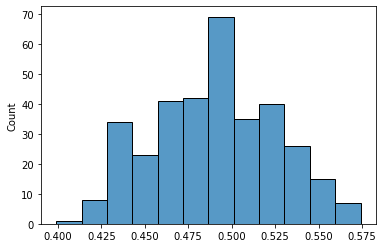

In [66]:
import seaborn as sns

probs = np.mean(np.array([est.predict_proba(X_test)[:,1] for est in clf.estimators_]), axis = 0)
sns.histplot(probs)

<AxesSubplot:ylabel='Count'>

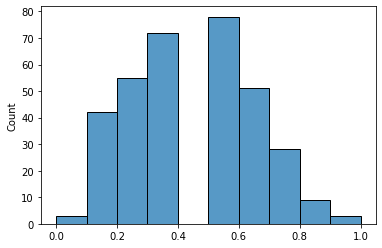

In [67]:
def unweighted_prediction(clf, X):
    preds = np.array([est.predict(X) for est in clf.estimators_])
    probs = np.mean(preds, axis = 0)
    pmax = np.max(probs)
    pmin = np.min(probs)
    return (probs - pmin) / (pmax - pmin)

sns.histplot(unweighted_prediction(clf, X_test))

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

# X_test[0].toarray()

X_train_array = X_train.toarray()
perc_feat_present = (X_train_array > 0).mean(axis=0)
common_feature_indicies = perc_feat_present > 0.5
common_features = feature_names[common_feature_indicies]
print(len(common_features))
common_features

#sns.displot(perc_feat_present, kind="kde")

# print(.shape)
# sns.histplot(X_train.toarray().mean(axis=0).round())

# np.apply_along_axis(lambda row: cosine_similarity(X_test[0]), 1, X_train)

127


array(['    ', '         ', '              ', '          if', '     #',
       '     # -', '     for', '     if', '     if is_odd', '     return',
       '     return a_number', '#', '# -', '# - -', '%', '% 2', '% 2 =',
       '(', '( [', '( a_number', '( a_number :', '( maximum_odd',
       '( maximum_odd (', ')', ') ,', ') -', ') - >', ') assert_equal',
       ') assert_equal (', ',', '-', '-     ', '-      return', '- -',
       '- -     ', '- >', '- > bool', '- > int', '0', '0 ]', '0 ]     ',
       '1', '1 def', '1 def maximum_odd', '2', '2 ,', '2 =', '2 = =', '3',
       ':', ':     ', ':          ', ':      #', ': [', ': [ int',
       ': int', ': int )', '=', '= 1', '= 1 def', '= =', '= = 1', '>',
       '> bool', '> bool :', '> int', '> int :', 'True', '[', '[ 0',
       '[ 0 ]', '[ int', '[ int ]', ']', ']     ', ']      for', '] )',
       '] ) ,', '] ) -', 'a_number', 'a_number %', 'a_number % 2',
       'a_number :', 'a_number : int', 'assert_equal', 'assert_equal (',
    

<AxesSubplot:ylabel='Count'>

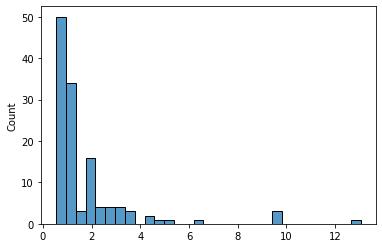

In [73]:
mean_features = X_train_array.mean(axis=0)
sns.histplot(mean_features[common_feature_indicies])

In [82]:
X_test[0:2]

<2x4993 sparse matrix of type '<class 'numpy.int64'>'
	with 486 stored elements in Compressed Sparse Row format>

In [85]:
def progress_score_single(features):
    completion = features[common_feature_indicies] / mean_features[common_feature_indicies]
    completion = np.clip(completion, 0, 1)
    return completion.mean()

def progress_score(X):
    test = X.toarray()
    return np.apply_along_axis(progress_score_single, 1, test)

progress_score(X_test[0:2])

array([0.86486878, 0.90134036])

<AxesSubplot:ylabel='Count'>

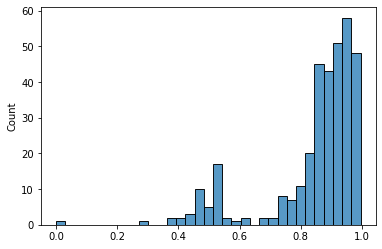

In [86]:
sns.histplot(progress_score(X_test))

In [87]:
query = f"""
select SubjectID, AssignmentID, CodeStateID, Contents from (
select SubjectID, AssignmentID, CodeStateID, CodeStateSection from MainTable where AssignmentId = "{assignmentID}" and EventType="File.Edit"
) as main JOIN CodeState where main.CodeStateID = CodeState.ID and main.CodeStateSection = CodeState.Filename
"""

con = sqlite3.connect("data/progsnap2_21_consenting_no_demographics.db")
all_edits = pd.read_sql_query(query, con)

all_edits

,SubjectID,AssignmentID,CodeStateID,Contents
0,750,139,403632,"b""from cisc108 import assert_equal\n\ndef is_o..."
1,750,139,403653,"b""from cisc108 import assert_equal\n\ndef is_o..."
2,750,139,403676,"b""from cisc108 import assert_equal\n\ndef is_o..."
3,750,139,403679,"b""from cisc108 import assert_equal\n\ndef is_o..."
4,750,139,403681,"b""from cisc108 import assert_equal\n\n\n\ndef ..."
...,...,...,...,...
9844,726,139,1021370,"b""from cisc108 import assert_equal\n\ndef is_o..."
9845,726,139,1021370,"b""from cisc108 import assert_equal\n\ndef is_o..."
9846,726,139,1021371,"b""from cisc108 import assert_equal\n\ndef is_o..."
9847,726,139,1021371,"b""from cisc108 import assert_equal\n\ndef is_o..."


In [91]:
X_edits_code = all_edits.Contents.str.decode('UTF-8').apply(strip_comments)
X_edits = vectorizer.transform(X_edits_code)

In [89]:
X_edits

<9849x4993 sparse matrix of type '<class 'numpy.int64'>'
	with 1977851 stored elements in Compressed Sparse Row format>

In [90]:
sample = pd.DataFrame({
    'Code': X_test_code,
    'Progress_score': progress_score(X_test),
    'Correctness_score': clf.predict_proba(X_test)[:,1],
    'Correct': y_test
})
sample.to_csv(f'data/out/p{assignmentID}.csv', index=False)
sample

,Code,Progress_score,Correctness_score,Correct
784,from cisc108 import assert_equal\n\ndef is_odd...,0.864869,0.471560,False
900,from cisc108 import assert_equal\n\ndef is_odd...,0.901340,0.132964,False
413,from cisc108 import assert_equal\n\ndef is_odd...,0.879139,0.554896,True
467,from cisc108 import assert_equal\n\ndef is_odd...,0.874611,0.506448,False
746,from cisc108 import assert_equal\n\ndef is_odd...,0.785203,0.505294,False
...,...,...,...,...
334,from cisc108 import assert_equal\n\ndef is_odd...,0.843478,0.518025,False
714,from cisc108 import assert_equal\n\ndef is_odd...,0.910437,0.499765,False
834,from cisc108 import assert_equal\n\ndef is_odd...,0.937846,0.582102,False
677,from cisc108 import assert_equal\n\ndef is_odd...,0.941102,0.147726,False


In [92]:
sample = pd.DataFrame({
    'Code': X_edits_code,
    'Progress_score': progress_score(X_edits),
    'Correctness_score': clf.predict_proba(X_edits)[:,1]
})
sample.to_csv(f'data/out/p{assignmentID}-edits.csv', index=False)
sample

,Code,Progress_score,Correctness_score
0,from cisc108 import assert_equal\n\ndef is_odd...,0.467335,0.024788
1,from cisc108 import assert_equal\n\ndef is_odd...,0.469860,0.025328
2,from cisc108 import assert_equal\n\ndef is_odd...,0.470266,0.025328
3,from cisc108 import assert_equal\n\ndef is_odd...,0.580528,0.024788
4,from cisc108 import assert_equal\n\n\n\ndef is...,0.580528,0.024788
...,...,...,...
9844,from cisc108 import assert_equal\n\ndef is_odd...,0.864622,0.022765
9845,from cisc108 import assert_equal\n\ndef is_odd...,0.864622,0.022765
9846,from cisc108 import assert_equal\n\ndef is_odd...,0.864622,0.022765
9847,from cisc108 import assert_equal\n\ndef is_odd...,0.864622,0.022765


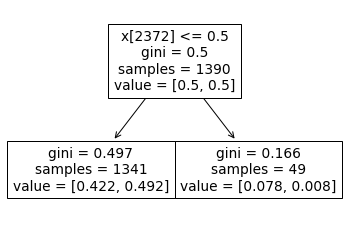

In [13]:
from sklearn.tree import plot_tree

def print_rule(clf, index):
    estimator = clf.estimators_[index]
#     name = feature_names[estimator.tree_.feature[0]]
#     thresh = estimator.tree_.threshold[0]
#     estimator_samples = clf.estimators_samples_[index]
#     children = estimator.apply(X_resampled[estimator_samples])
#     perc_child_1 = np.mean(y_resampled[estimator_samples][children == 1])
#     perc_child_2 = np.mean(y_resampled[estimator_samples][children == 2])
#     pred_child_1 = perc_child_1 > 0.5
#     pred_child_2 = perc_child_2 > 0.5
#     if pred_child_1 and pred_child_2:
#         print(f"Degenerate rule: always {pred_child_1}")
#         return
#     if pred_child_1:
#         print (f"If {name} < {thresh}, True")
#     else:
#         print (f"If {name} > {thresh}, True")
    plot_tree(estimator)
    
print_rule(clf, 8)

In [14]:
[feature_names[est.tree_.feature[0]] for est in clf.estimators_]

['is_odd (',
 'maximum_odd (',
 '10 ]',
 '6',
 '= 0     ',
 '2 , 7',
 'item ) =',
 'and',
 '= highest',
 ', 2 ,',
 ') >',
 '( number',
 ', 4 ,',
 '13',
 '[ 0 ]',
 '22 ) ,',
 '          return',
 '[ 2',
 ':      max_odd',
 '] )     ']